In [1]:
import sctop as top
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns

In [22]:
sns.set_theme(context='talk', 
              color_codes=True, 
              palette='deep', 
              style='whitegrid',
              font_scale=1,
              rc={'mathtext.fontset': 'cm', 
              'xtick.direction': 'in',
              'ytick.direction': 'in',
              'axes.linewidth': 1.5,
              'figure.dpi':100,
#               'text.usetex':True
                 }
             )

Read data from the [TCGA Pan-Cancer Atlas](https://xenabrowser.net/datapages/?cohort=TCGA%20Pan-Cancer%20(PANCAN)&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443), and only look at samples that have type annotations
- `expression_tpm` : [gene expression RNAseq - TOIL RSEM tpm](https://xenabrowser.net/datapages/?dataset=tcga_RSEM_gene_tpm&host=https%3A%2F%2Ftoil.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443) (tcga_RSEM_gene_tpm.gz)
- `cancer_types` : [sample type and primary disease](https://xenabrowser.net/datapages/?dataset=TCGA_phenotype_denseDataOnlyDownload.tsv&host=https%3A%2F%2Fpancanatlas.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443) (TCGA_phenotype_denseDataOnlyDownload.tsv.gz)
- `patient_info` : [curated clinical data](https://xenabrowser.net/datapages/?dataset=Survival_SupplementalTable_S1_20171025_xena_sp&host=https%3A%2F%2Fpancanatlas.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443) (Survival_SupplementalTable_S1_20171025_xena_sp)

In [3]:
directory = '/projectnb/biophys/mariay/Pan-Cancer Atlas/'

expression_tpm = pd.read_csv(directory + 'tcga_RSEM_gene_tpm.gz', sep='\t')
expression_tpm = expression_tpm.set_index('sample')

cancer_types = pd.read_csv(directory + 'TCGA_phenotype_denseDataOnlyDownload.tsv.gz', sep='\t')
cancer_types = cancer_types.set_index('sample')

patient_info = pd.read_csv(directory + 'Survival_SupplementalTable_S1_20171025_xena_sp', sep='\t')
patient_info = patient_info.set_index('sample')

samples_in_common = np.intersect1d(cancer_types.index, expression_tpm.columns)
cancer_types = cancer_types.loc[samples_in_common]
expression_tpm = expression_tpm.loc[:, samples_in_common]

Look at the cancer types in the atlas and corresponding number of samples

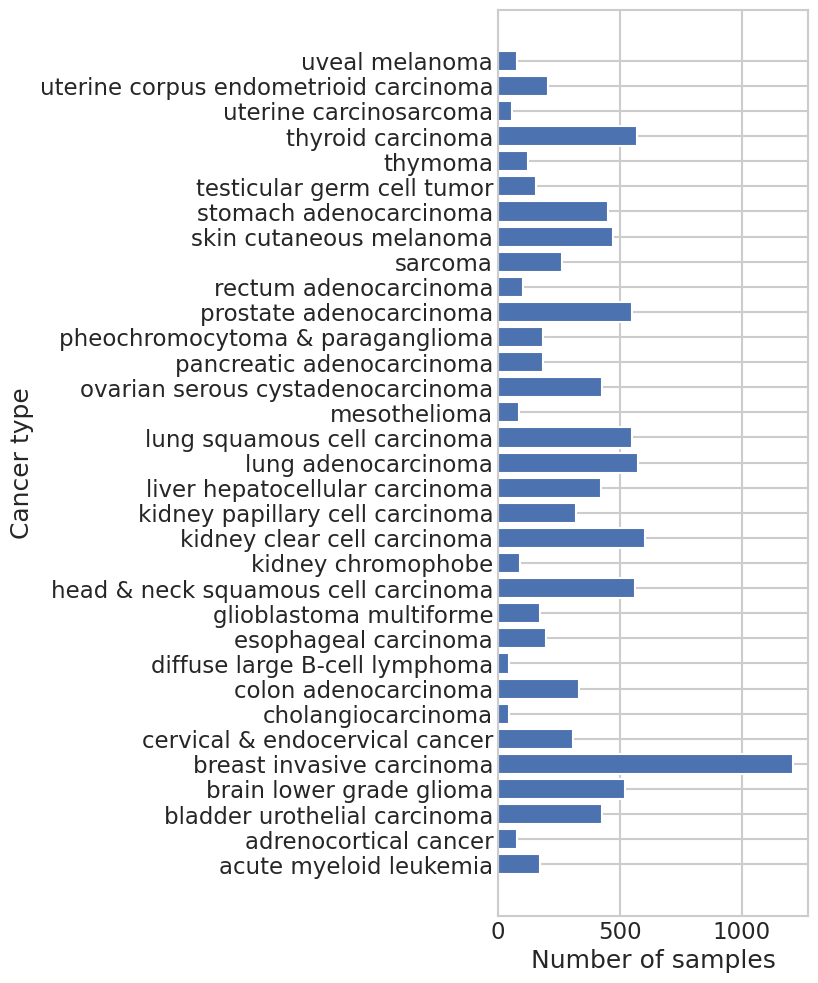

In [23]:
cancer_names, cancer_counts = np.unique(cancer_types.loc[:, '_primary_disease'], return_counts = True)

plt.figure(figsize=(4, 12))
plt.barh(cancer_names, cancer_counts)
plt.xlabel('Number of samples')
plt.ylabel('Cancer type')
plt.show()

Randomly select `number_samples` samples of each cancer type, take the average, process, and add to `cancer_basis`

In [5]:
from numpy.random import default_rng
rng = default_rng()

# Choose the number of samples to average over for each type
number_samples = 20

expression_list = []
training_ids = []

for current_type in tqdm(cancer_names):
    current_type_ids = cancer_types.index[cancer_types.loc[:, '_primary_disease'] == current_type]

    random_ids = rng.choice(current_type_ids, number_samples, replace=False)
    training_ids += [random_ids]
    
    current_tpm = expression_tpm.loc[:, random_ids]
    current_processed = top.process(current_tpm, average=True)
    expression_list.append(current_processed)

training_ids = np.concatenate(training_ids)
cancer_basis = pd.concat(expression_list, axis=1)
cancer_basis.columns = cancer_names
cancer_basis.index = cancer_basis.index.rename('gene')

100%|██████████| 33/33 [00:00<00:00, 55.02it/s]


Find the scTOP scores for all samples that weren't used to create the basis

In [6]:
test_ids = cancer_types.index
test_ids = np.setdiff1d(test_ids, training_ids)

test_processed = top.process(expression_tpm.loc[:, test_ids])
test_projections = top.score(cancer_basis, test_processed)

Find the top1 and top3 accuracies for scTOP

In [7]:
# cells with maximum projection under this value are considered "unspecified"
specification_value = 0.1

accuracies = {'top1': 0,
              'top3': 0,
              'unspecified': 0
             }

predicted_labels = []
predicted_labels_specified = []
true_labels = []

for sample_id, sample_projections in test_projections.iteritems():
    
    types_sorted_by_projections = sample_projections.sort_values(ascending=False).index
    true_type = cancer_types.loc[sample_id, '_primary_disease']
    
    true_labels += [true_type]
    top_type = types_sorted_by_projections[0]
    predicted_labels += [top_type]
    
    if sample_projections.max() < specification_value:
        predicted_labels_specified += ['Unspecified']
        accuracies['unspecified'] += 1
    else:
        predicted_labels_specified += [top_type]
    
    if top_type == true_type:
        accuracies['top1'] += 1
    if true_type in types_sorted_by_projections[:3]:
        accuracies['top3'] += 1

In [8]:
number_test_samples = len(test_ids)

print('Accuracy statistics for {} test samples and {} training samples per cancer type'.format(number_test_samples, number_samples))

for key, value in accuracies.items():
    print('{}: {:.2f}%'.format(key, 100*value/number_test_samples))

Accuracy statistics for 9874 test samples and 20 training samples per cancer type
top1: 81.12%
top3: 95.22%
unspecified: 0.01%


Let's look at the top 10 projections for one random sample

True type: ovarian serous cystadenocarcinoma


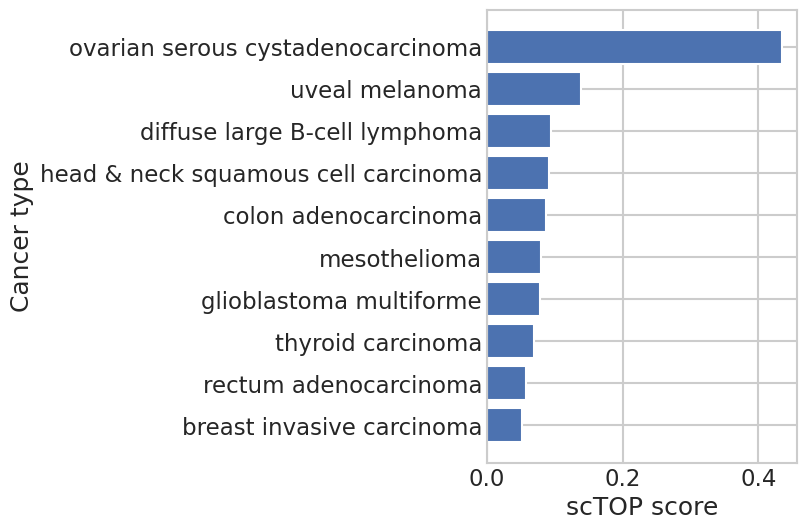

In [37]:
sample_id = rng.choice(test_projections.columns)
print('True type: {}'.format(cancer_types.loc[sample_id, '_primary_disease']))

sample_projections = test_projections.loc[:, sample_id]
top_10 = sample_projections.sort_values(ascending=False).index[:10]

plt.figure(figsize=(4, 6))
plt.barh(top_10, sample_projections.loc[top_10])
plt.gca().invert_yaxis()
plt.xlabel('scTOP score')
plt.ylabel('Cancer type')
plt.show()

Let's plot scores for two basis types. Each point corresponds to a sample.

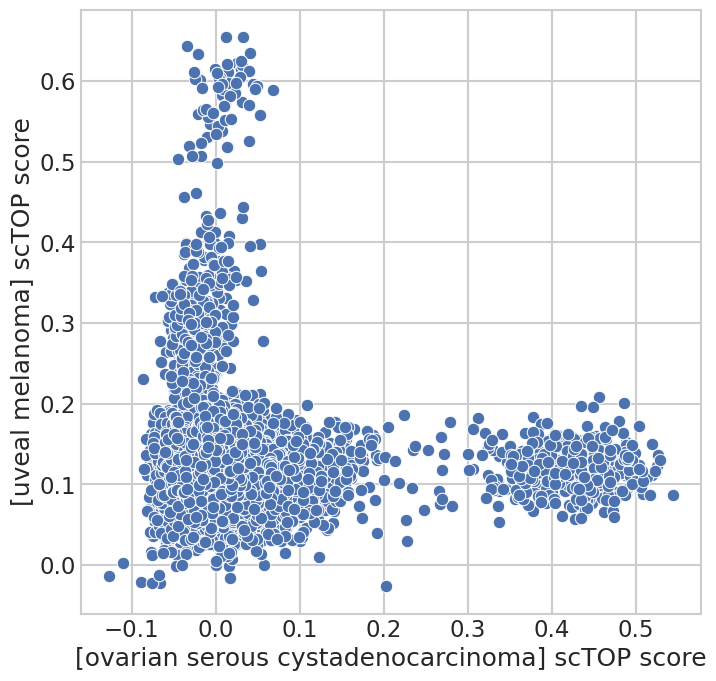

In [40]:
# An example where the cancer types are relatively easy to distinguish

type_x = 'ovarian serous cystadenocarcinoma'
type_y = 'uveal melanoma'

plt.figure(figsize=(8,8))
sns.scatterplot(x = test_projections.loc[type_x],
                y = test_projections.loc[type_y]
               )
plt.xlabel('[{}] scTOP score'.format(type_x))
plt.ylabel('[{}] scTOP score'.format(type_y))
plt.show()

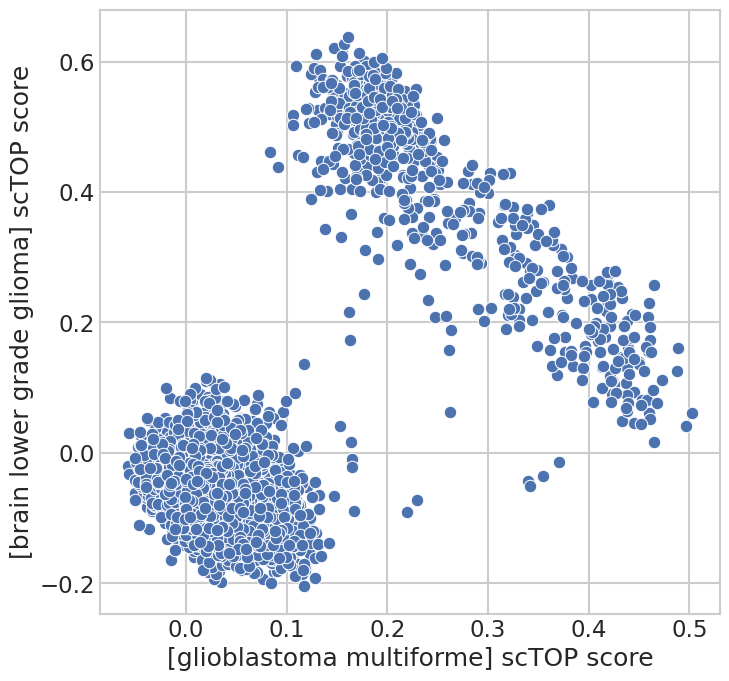

In [25]:
# An example where the cancer types appear to exist on a spectrum

type_x = 'glioblastoma multiforme'
type_y = 'brain lower grade glioma'

plt.figure(figsize=(8,8))
sns.scatterplot(x = test_projections.loc[type_x],
                y = test_projections.loc[type_y]
               )
plt.xlabel('[{}] scTOP score'.format(type_x))
plt.ylabel('[{}] scTOP score'.format(type_y))
plt.show()

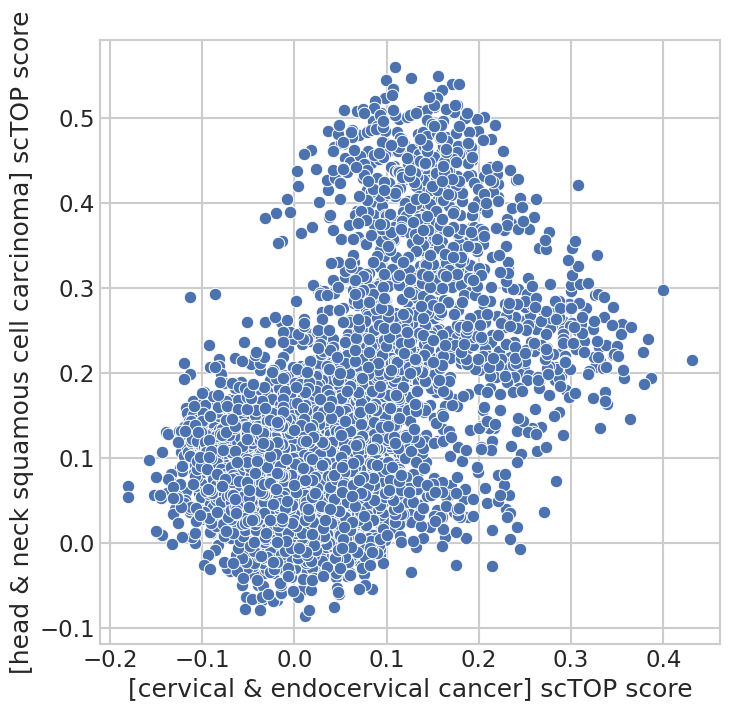

In [39]:
# An example where the cancer types are difficult to distinguish

type_x = 'cervical & endocervical cancer'
type_y = 'head & neck squamous cell carcinoma'

plt.figure(figsize=(8,8))
sns.scatterplot(x = test_projections.loc[type_x],
                y = test_projections.loc[type_y]
               )
plt.xlabel('[{}] scTOP score'.format(type_x))
plt.ylabel('[{}] scTOP score'.format(type_y))
plt.show()